---
# Tutorial Objectives

 In this tutorial, we will learn how to infer a latent model when our states are continuous. Particular attention is paid to the Kalman filter and it's mathematical foundation.

In this tutorial, you will:
* Review linear dynamical systems
* Learn about and implement the Kalman filter



In [ ]:
# Install PyKalman (https://pykalman.github.io/)
!pip install pykalman --quiet
!pip install matplotlib --upgrade

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pykalman
from scipy import stats

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 251.6/251.6 kB 5.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.3/8.3 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [ ]:
#@title Helper functions
np.set_printoptions(precision=3)


def plot_kalman(state, observation, estimate=None, label='filter', color='r-',
                title='LDS', axes=None):
    if axes is None:
      fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
      ax1.plot(state[:, 0], state[:, 1], 'g-', label='true latent')
      ax1.plot(observation[:, 0], observation[:, 1], 'k.', label='data')
    else:
      ax1, ax2 = axes

    if estimate is not None:
      ax1.plot(estimate[:, 0], estimate[:, 1], color=color, label=label)
    ax1.set(title=title, xlabel='X position', ylabel='Y position')
    ax1.legend()

    if estimate is None:
      ax2.plot(state[:, 0], observation[:, 0], '.k', label='dim 1')
      ax2.plot(state[:, 1], observation[:, 1], '.', color='grey', label='dim 2')
      ax2.set(title='correlation', xlabel='latent', ylabel='observed')
    else:
      ax2.plot(state[:, 0], estimate[:, 0], '.', color=color,
               label='latent dim 1')
      ax2.plot(state[:, 1], estimate[:, 1], 'x', color=color,
               label='latent dim 2')
      ax2.set(title='correlation',
              xlabel='real latent',
              ylabel='estimated latent')
    ax2.legend()

    return ax1, ax2


def plot_kf_state(kf, data, ax):
    mu_0 = np.ones(kf.n_dim_state)
    mu_0[:data.shape[1]] = data[0]
    kf.initial_state_mean = mu_0

    mu, sigma = kf.smooth(data)
    ax.plot(mu[:, 0], mu[:, 1], 'limegreen', linewidth=3, zorder=1)
    ax.scatter(mu[0, 0], mu[0, 1], c='orange', marker='>', s=200, zorder=2)
    ax.scatter(mu[-1, 0], mu[-1, 1], c='orange', marker='s', s=200, zorder=2)

---
# Section 1: Linear Dynamical System (LDS)

ÏãúÍ∞ÑÏóê Îî∞Îùº ÏÑ†ÌòïÏ†ÅÏúºÎ°ú ÏÉÅÌÉú Î≥ÄÏàòÍ∞Ä Î≥ÄÌïòÎäî ÏãúÏä§ÌÖúÏùÄ Îã§ÏùåÍ≥º Í∞ôÏù¥ Î™®Îç∏ÎßÅ Í∞ÄÎä•ÌïòÎã§.

Latent state variable (Ïû†Ïû¨ ÏÉÅÌÉú Î≥ÄÏàò): $$s_t = Fs_{t-1}+\zeta_t$$

Measured/observed variable (Ï∏°Ï†ï Î≥ÄÏàò): $$y_t = Hs_{t}+\eta_t$$

Both latent and measured variable have Gaussian noise terms:

\begin{eqnarray}
\zeta_t & \sim & N(0, Q) \\
\eta_t & \sim & N(0, R) \\
s_0 & \sim & N(\mu_0, \Sigma_0)
\end{eqnarray}

## Section 1.1: Sampling

The first thing we will investigate is how to generate timecourse samples from a linear dynamical system given its parameters. We will start by defining the following system:

In [ ]:
# task dimensions
n_dim_state = 2 # ÏÉÅÌÉú Î≥ÄÏàòÏùò Ï∞®ÏõêÏù¥ 2ÎùºÍ≥† Í∞ÄÏ†ï
n_dim_obs = 2 # Í¥ÄÏ∏° Î≥ÄÏàòÏùò Ï∞®ÏõêÏù¥ 2ÎùºÍ≥† Í∞ÄÏ†ï

# initialize model parameters
params = {
  'F': 0.5 * np.eye(n_dim_state),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 0.1 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

**Note**: We used a parameter dictionary `params` above. As the number of parameters we need to provide to our functions increases, it can be beneficial to condense them into a data structure like this to clean up the number of inputs we pass in. The trade-off is that we have to know what is in our data structure to use those values, rather than looking at the function signature directly.

### Exercise 1: Sampling from a linear dynamical system

In this exercise you will implement the dynamics functions of a linear dynamical system to sample both a latent space trajectory (given parameters set above) and noisy measurements.


sample at t=3  [ 2.105 -0.124]


(<Axes: title={'center': 'sample'}, xlabel='X position', ylabel='Y position'>,
 <Axes: title={'center': 'correlation'}, xlabel='latent', ylabel='observed'>)

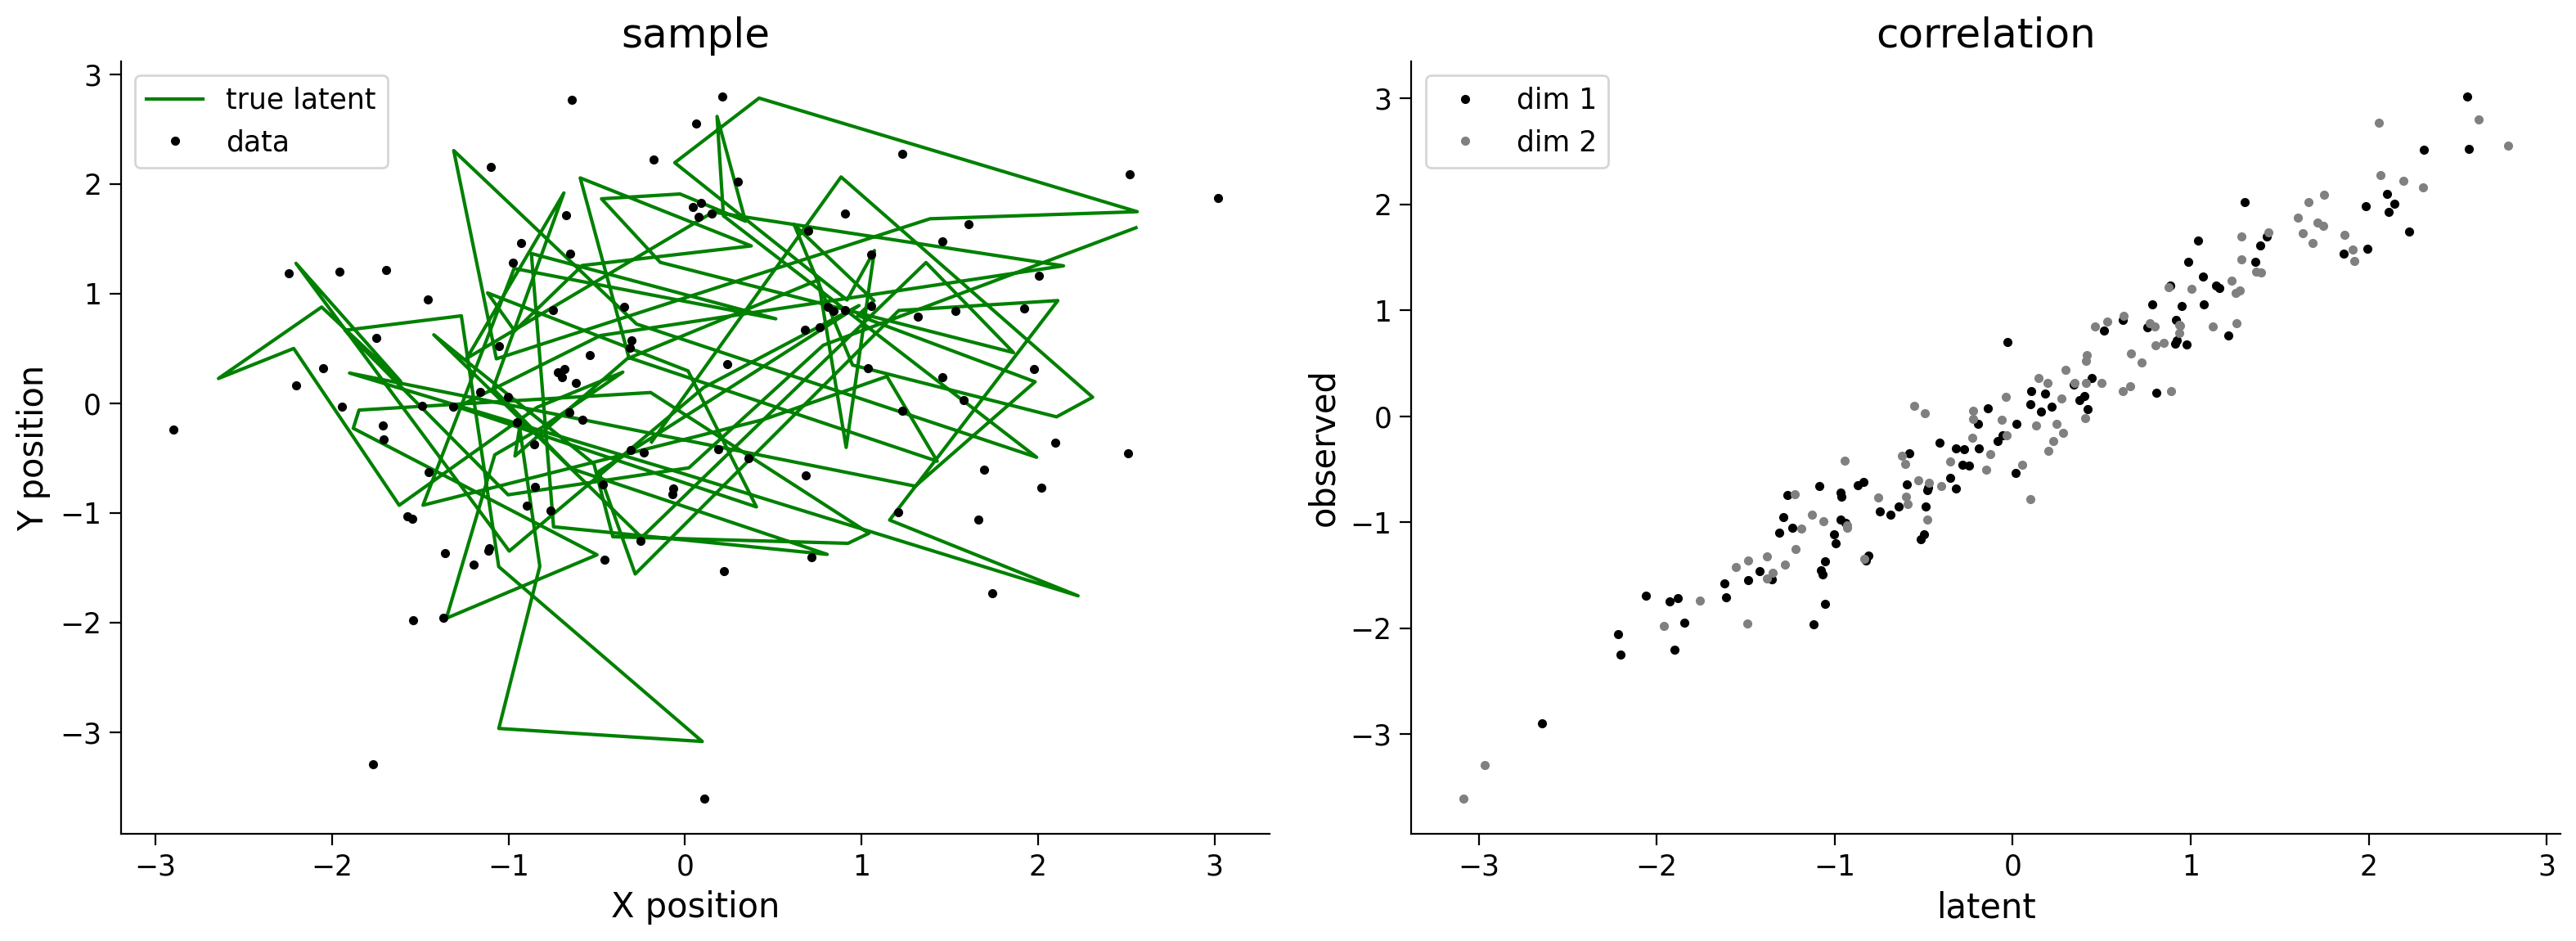

In [ ]:
def sample_lds(n_timesteps, params, seed=0):
  """
  Ï£ºÏñ¥ÏßÑ ÌååÎùºÎØ∏ÌÑ∞Ïóê ÏùòÌï¥ Ï†ïÏùòÎêú ÏÑ†Ìòï ÎèôÏ†Å ÏãúÏä§ÌÖú(Linear Dynamical System)ÏóêÏÑú ÏÉòÌîåÏùÑ ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.

  Args:
  n_timesteps (int): ÏãúÎÆ¨Î†àÏù¥ÏÖòÌï† ÏãúÍ∞Ñ Îã®Í≥ÑÏùò Ïàò
  params (dict): Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞Í∞Ä Ìè¨Ìï®Îêú Dictionary (F, Q, H, R, mu_0, sigma_0)
  seed (int): Ïû¨ÌòÑÏÑ± Í≤ÄÏÇ¨Î•º ÏúÑÌïú ÎûúÎç§ ÏãúÎìú Í∞í

  Returns:
  ndarray, ndarray: ÏÉùÏÑ±Îêú ÏÉÅÌÉúÏôÄ Í¥ÄÏ∏° Îç∞Ïù¥ÌÑ∞
  """

  # ÏÉÅÌÉú(state) Î≤°ÌÑ∞Ïùò Ï∞®Ïõê Ïàò Ï†ïÏùò (F ÌñâÎ†¨Ïùò Ï≤´ Î≤àÏß∏ Ï∞®ÏõêÏù¥ ÏÉÅÌÉú Î≤°ÌÑ∞Ïùò Ï∞®Ïõê)
  n_dim_state = params['F'].shape[0]

  # Í¥ÄÏ∏°(observation) Î≤°ÌÑ∞Ïùò Ï∞®Ïõê Ïàò Ï†ïÏùò (H ÌñâÎ†¨Ïùò Ï≤´ Î≤àÏß∏ Ï∞®ÏõêÏù¥ Í¥ÄÏ∏° Î≤°ÌÑ∞Ïùò Ï∞®Ïõê)
  n_dim_obs = params['H'].shape[0]
  np.random.seed(seed)

  # Multivariate Normal DistributionÎ°úÎ∂ÄÌÑ∞ ÏÉÅÌÉú Ïû°Ïùå(zi)ÏôÄ Í¥ÄÏ∏° Ïû°Ïùå(eta)ÏùÑ ÏÉùÏÑ±Ìï®
  # ÏÉÅÌÉú Ïû°Ïùå ziÎäî Í≥µÎ∂ÑÏÇ∞ ÌñâÎ†¨ QÏóê ÏùòÌï¥ Ï†ïÏùòÎêòÍ≥†, Í¥ÄÏ∏° Ïû°Ïùå etaÎäî Í≥µÎ∂ÑÏÇ∞ ÌñâÎ†¨ RÏóê ÏùòÌï¥ Ï†ïÏùòÎê®
  zi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps)
  eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)

  state = np.zeros((n_timesteps, n_dim_state))
  obs = np.zeros((n_timesteps, n_dim_obs))

  # ÏãúÏä§ÌÖúÏùÑ ÏãúÎÆ¨Î†àÏù¥ÏÖòÌï® (ÏãúÍ∞Ñ tÏóê Îî∞Îùº ÏÉÅÌÉúÏôÄ Í¥ÄÏ∏°ÏπòÎ•º Í≥ÑÏÇ∞)
  for t in range(n_timesteps):
    if t == 0:
      # Ï¥àÍ∏∞ ÏÉÅÌÉúÎäî Ï£ºÏñ¥ÏßÑ Ï¥àÍ∏∞ ÌèâÍ∑†(mu_0) Î∞è Ï¥àÍ∏∞ Í≥µÎ∂ÑÏÇ∞(sigma_0)Ïóê Îî∞Îùº ÏÑ§Ï†ï
      state[t] = stats.multivariate_normal(mean=params['mu_0'],
                                           cov=params['sigma_0']).rvs(1)
    else:
      #### TODO Í∑∏ Ïô∏Ïùò ÏÉÅÌÉúÎäî Ïù¥Ï†Ñ ÏÉÅÌÉúÏóê Ï†ÑÏù¥ ÌñâÎ†¨ FÎ•º Í≥±ÌïòÍ≥† ÏÉÅÌÉú noise ziÎ•º ÎçîÌïòÏó¨ Í≥ÑÏÇ∞ ####
      state[t] = params["F"] @ state[t-1] + zi[t]

    #### TODO Í¥ÄÏ∏° Í∞íÏùÄ ÌòÑÏû¨ ÏÉÅÌÉúÏóê Í¥ÄÏ∏° ÌñâÎ†¨ HÎ•º Í≥±ÌïòÍ≥† Í¥ÄÏ∏° Ïû°Ïùå etaÎ•º ÎçîÌïòÏó¨ Í≥ÑÏÇ∞####
    obs[t] = params["H"] @ state[t] + eta[t]

  return state, obs

# 100Í∞úÏùò ÏãúÍ∞Ñ Îã®Í≥ÑÏóê ÎåÄÌï¥ ÌååÎùºÎØ∏ÌÑ∞Î•º Ïù¥Ïö©ÌïòÏó¨ ÏÑ†Ìòï ÎèôÏ†Å ÏãúÏä§ÌÖú ÏÉòÌîåÏùÑ ÏÉùÏÑ±Ìï®
state, obs = sample_lds(100, params)

# ÏãúÍ∞Ñ Îã®Í≥Ñ 3ÏóêÏÑúÏùò ÏÉÅÌÉú(state)Î•º Ï∂úÎ†•Ìï®
print('sample at t=3 ', state[3])

# ÏÉÅÌÉúÏôÄ Í¥ÄÏ∏° Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÏπºÎßå ÌïÑÌÑ∞Ïùò ÎèôÏûëÏùÑ ÏãúÍ∞ÅÌôîÌï®
plot_kalman(state, obs, title='sample')

*Example output:*

<img alt='Solution hint' align='left' width=1133 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_8cfee88d_1.png>



### Interactive Demo: Adjusting System Dynamics
To test your understanding of the parameters of a linear dynamical system, think about what you would expect if you made the following changes:
1. Reduce observation noise $R$
2. Increase respective temporal dynamics $F$

Use the interactive widget below to vary the values of $R$ and $F$.

interactive(children=(FloatLogSlider(value=0.1, description='R', max=1.0, min=-3.0), FloatSlider(value=0.5, de‚Ä¶

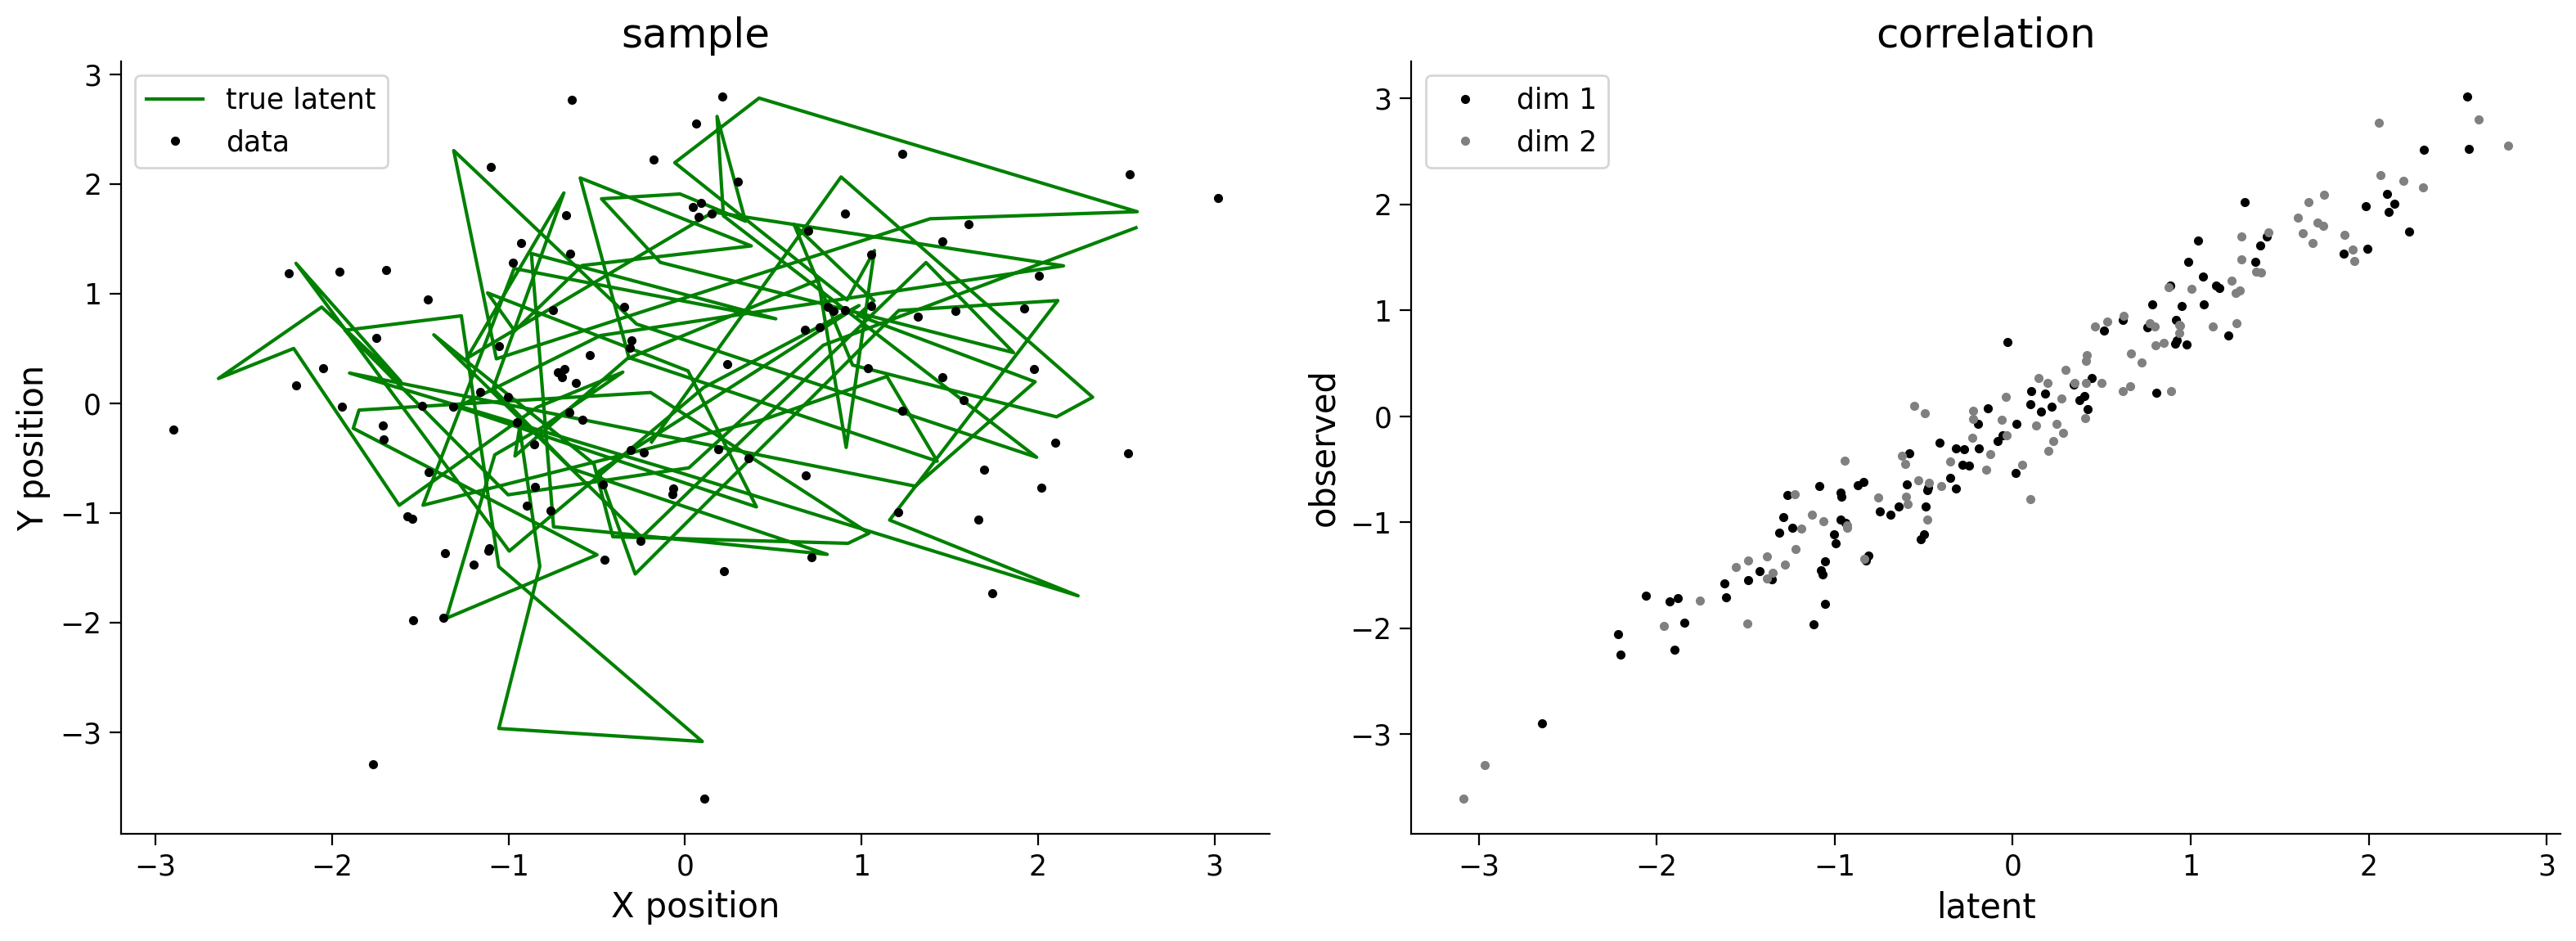

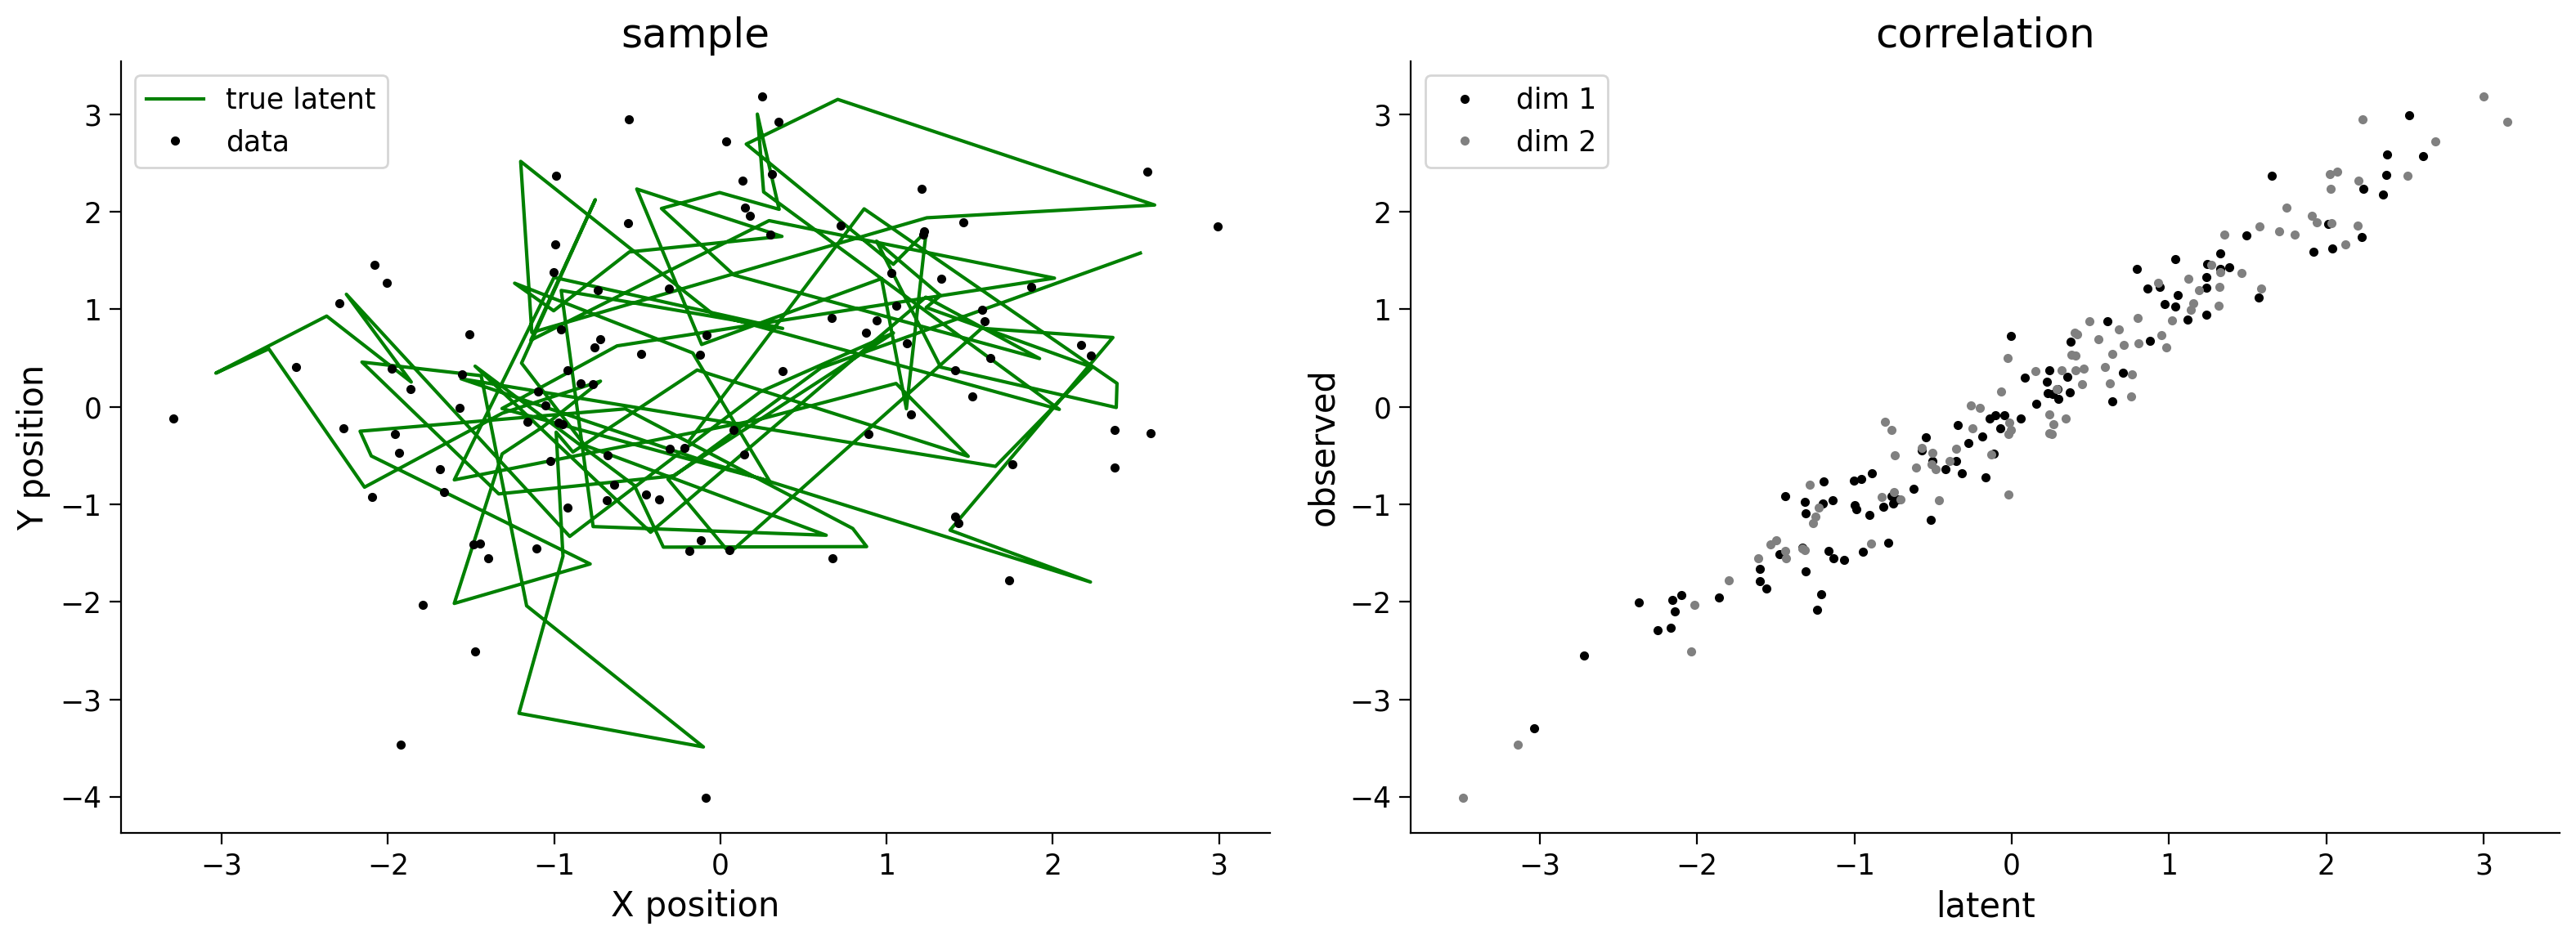

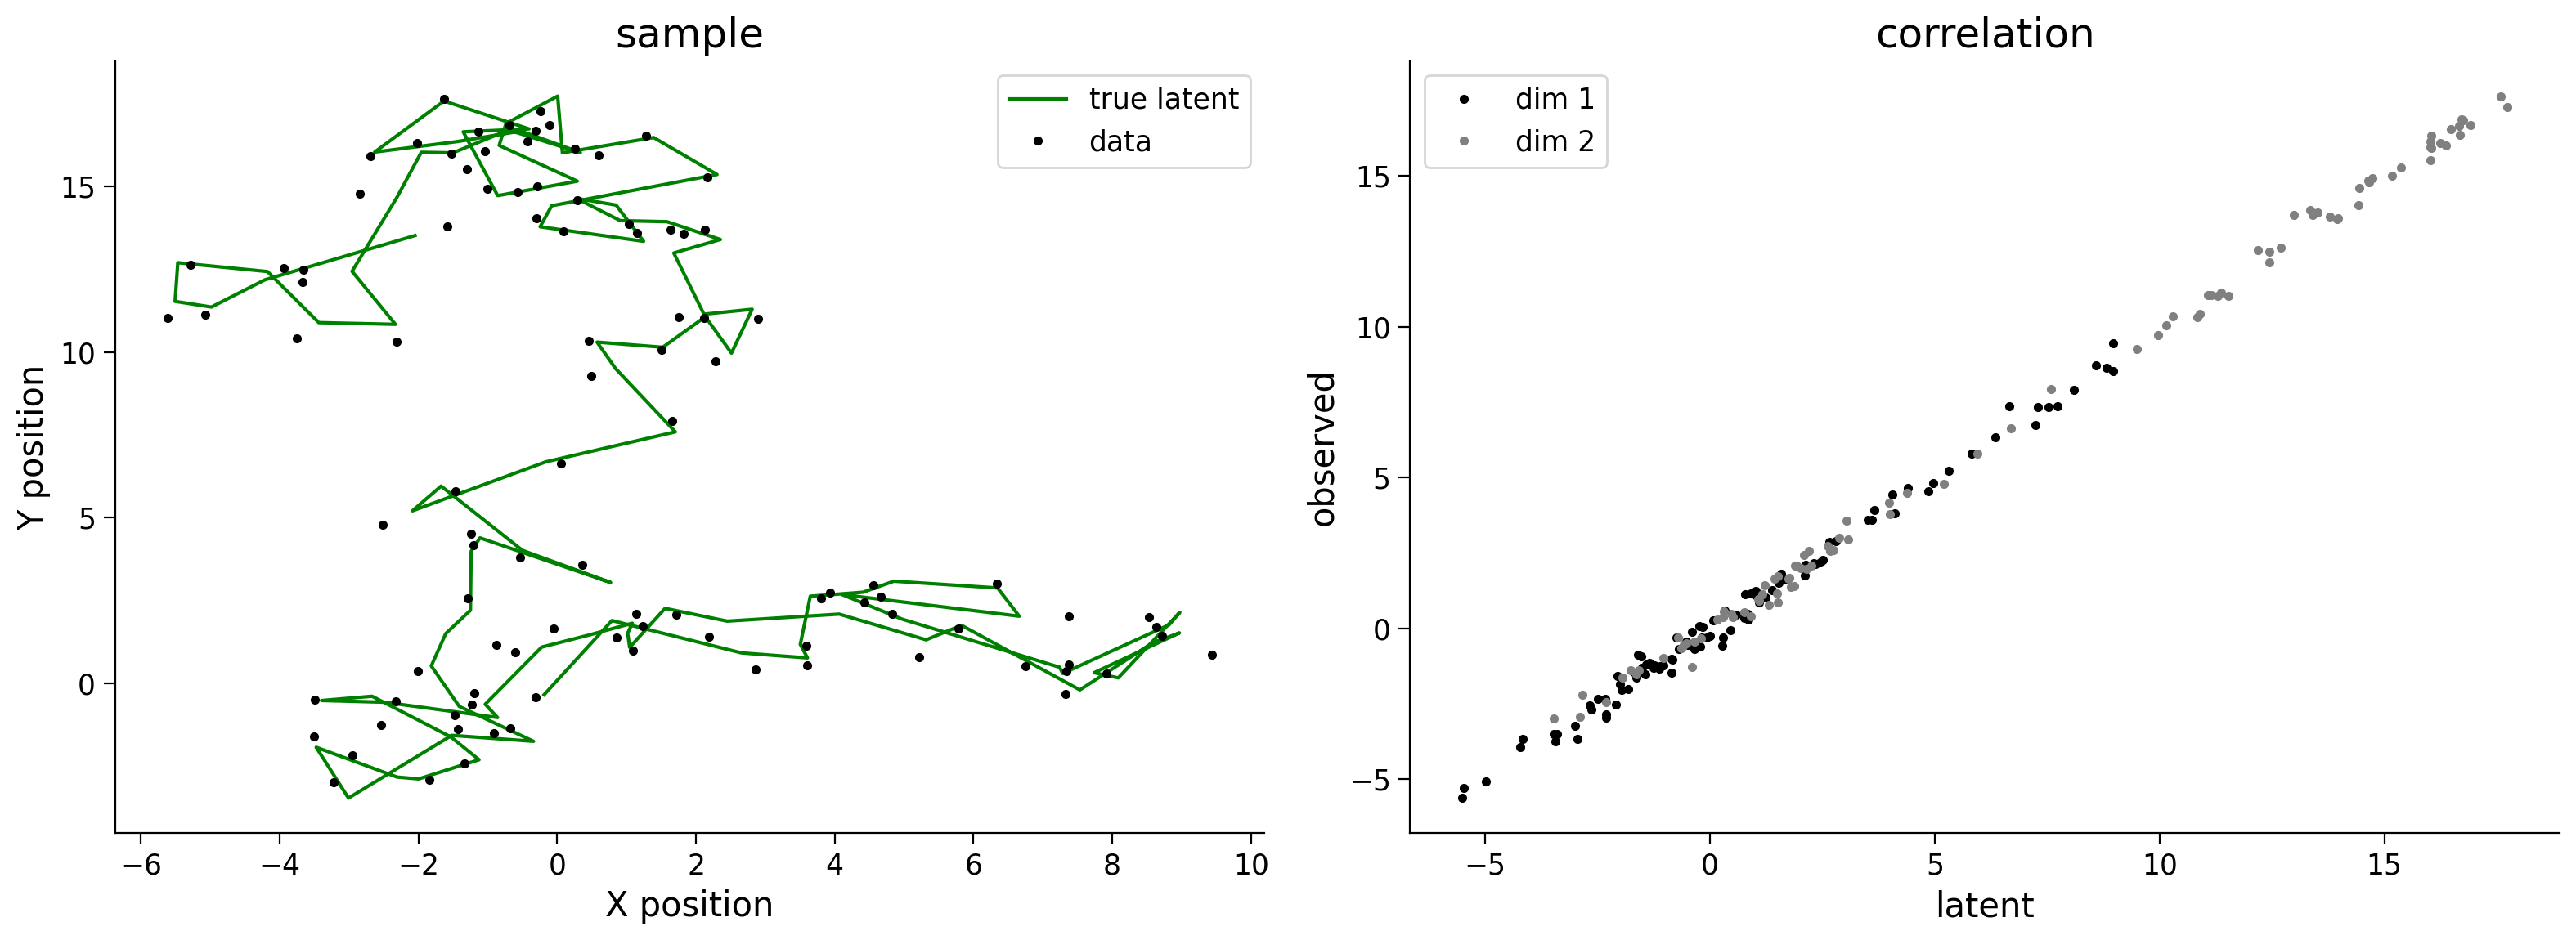

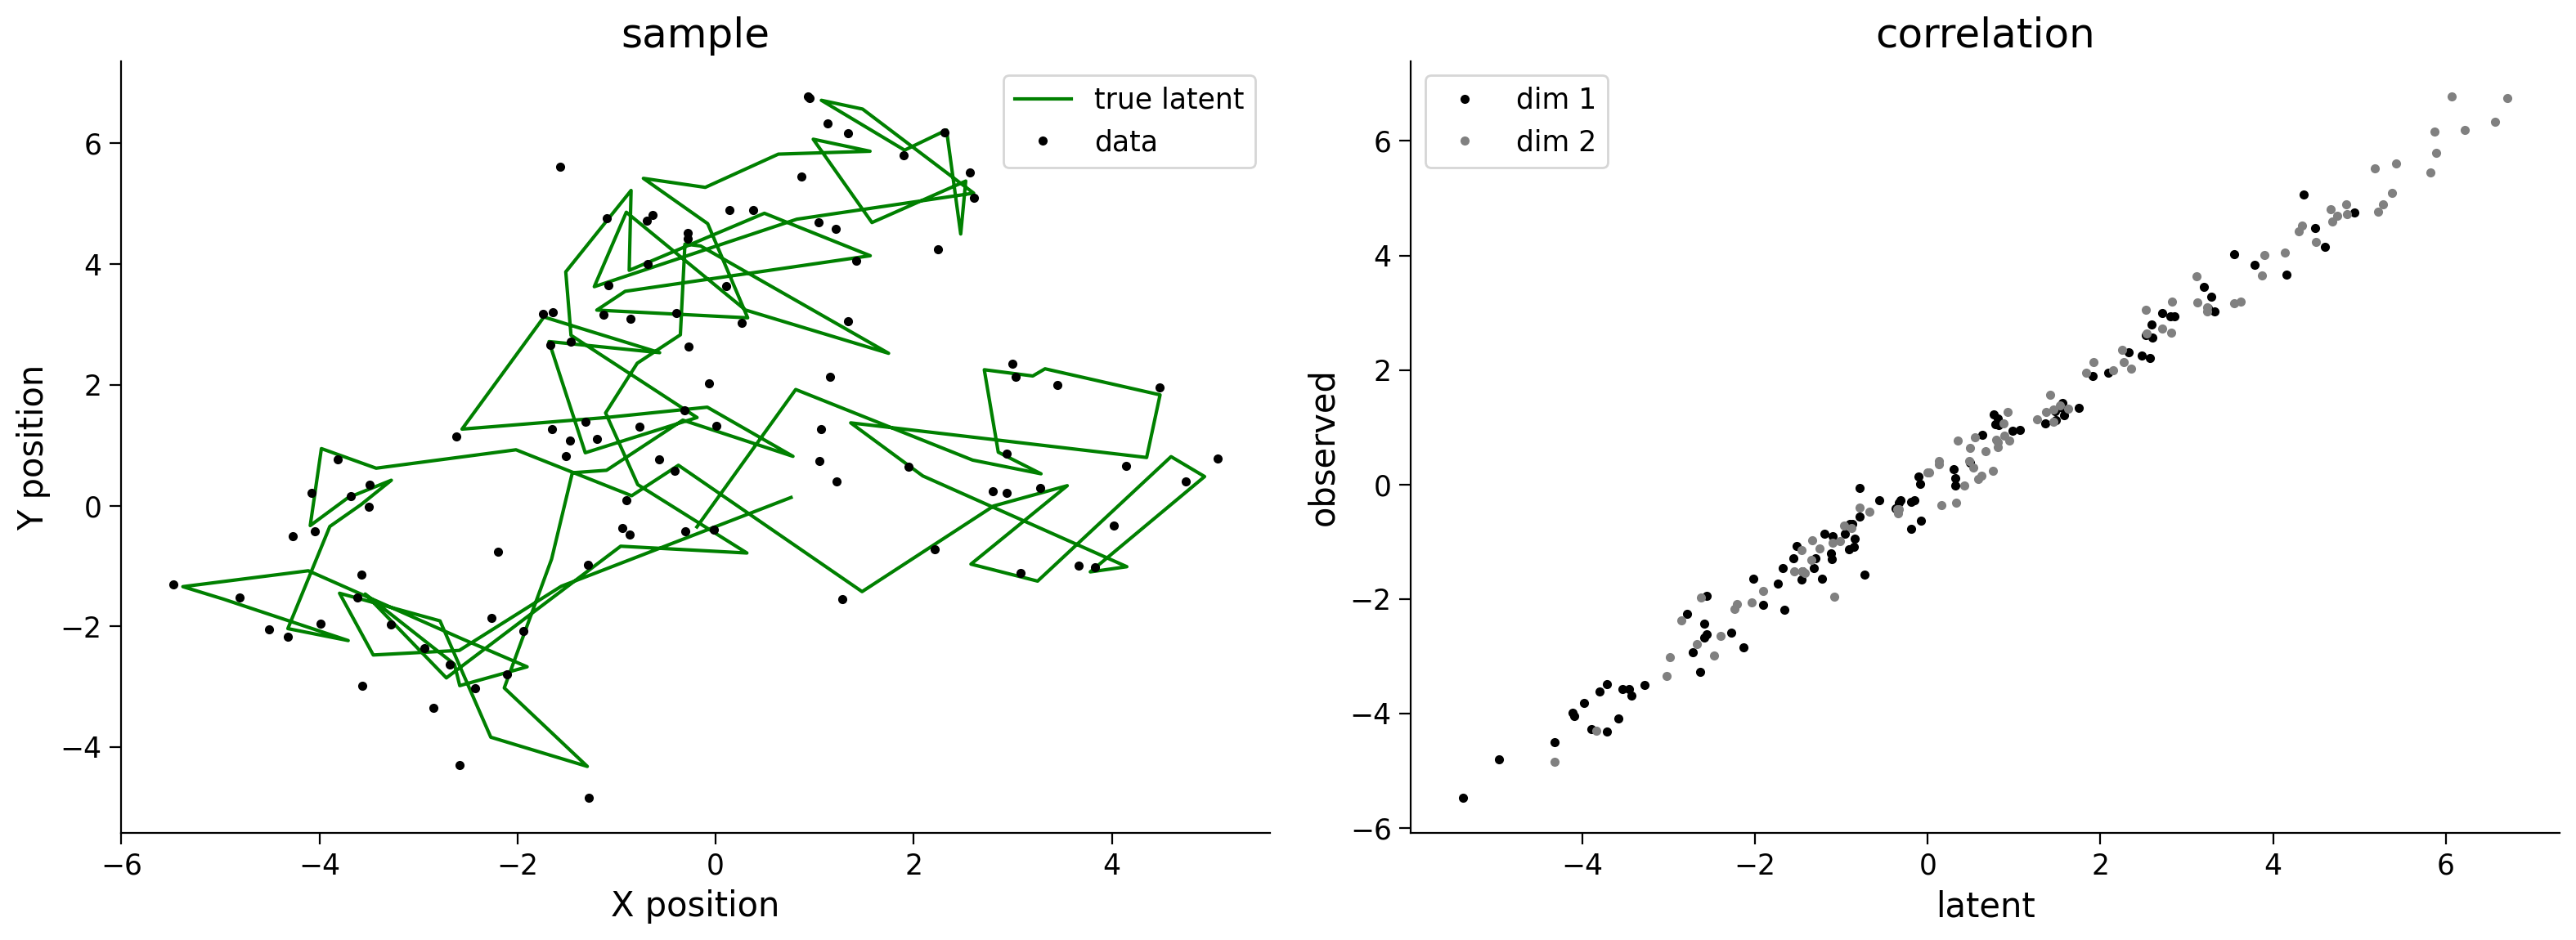

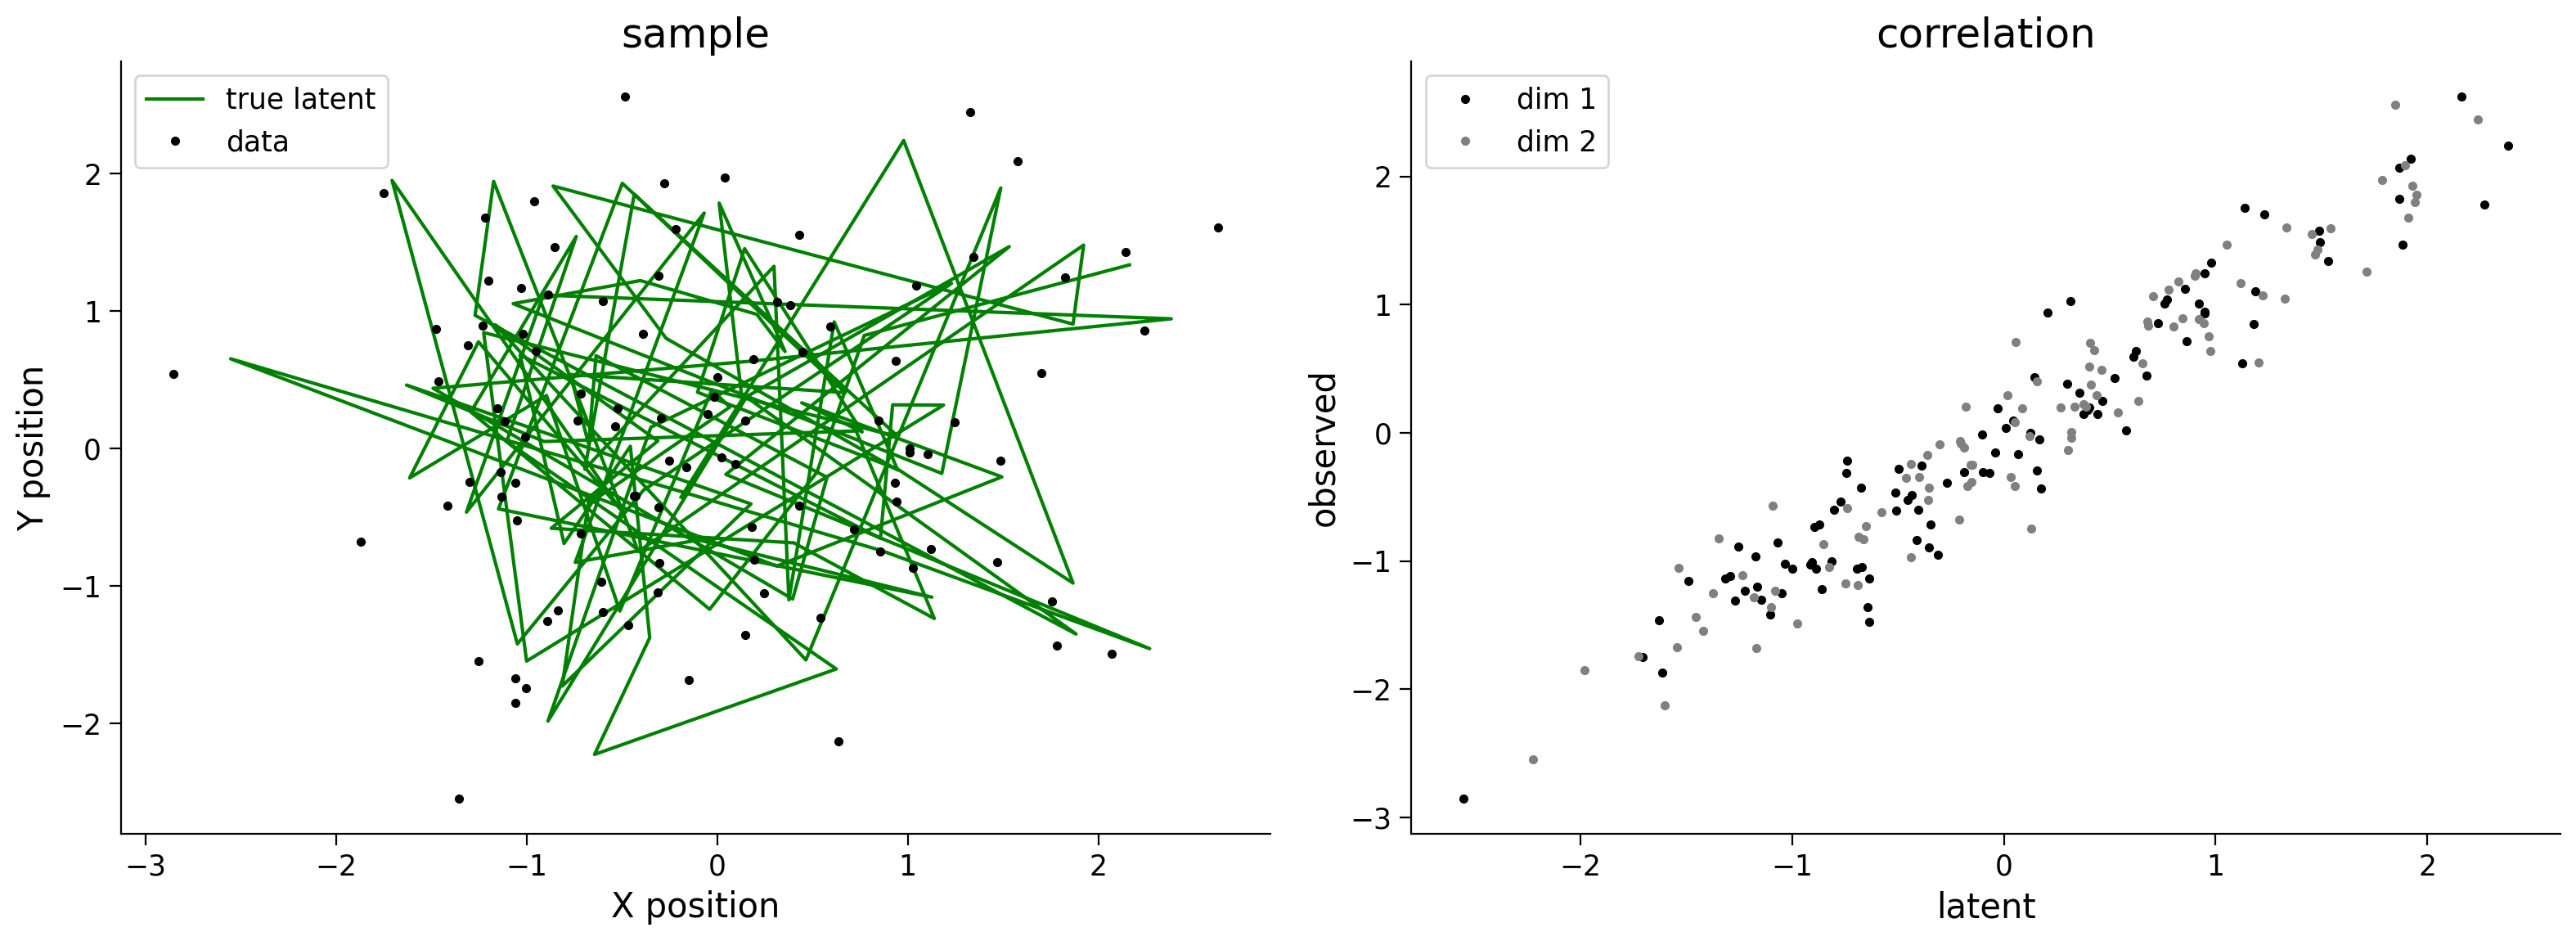

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

# RÍ∞Ä ÏûëÏùÑÏàòÎ°ù, Ï¶â Í¥ÄÏ∏° Ïû°ÏùåÏù¥ ÏûëÏùÑÏàòÎ°ù correlationÏùÄ 1Ïóê Í∞ÄÍπåÏõåÏßëÎãàÎã§.
# F=1Ïùº Í≤ΩÏö∞, ÏÉÅÌÉú Î≤°ÌÑ∞Îäî ÏãúÍ∞ÑÏóê Îî∞Îùº Î≥ÄÌïòÏßÄ ÏïäÎäî ÏÉÅÏàòÎ°ú Ïú†ÏßÄ
#(Î¨ºÎ°† Ïû°Ïùå ùë§ùë° Ïùò ÏòÅÌñ•ÏúºÎ°ú ÎØ∏ÏÑ∏Ìïú Î≥ÄÌôîÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏßÄÎßå, ÌèâÍ∑†Ï†ÅÏúºÎ°ú ÎèôÏùºÌïú Í∞íÏùÑ Ïú†ÏßÄÌïòÎ†§Îäî Í≤ΩÌñ•Ïù¥ ÏûàÏäµÎãàÎã§).

# FÍ∞Ä Ïª§ÏßÑÎã§Îäî Í≤ÉÏùÄ Ïù¥Ï†Ñ ÏÉÅÌÉúÏóê ÎåÄÌïú ÌòÑÏû¨ ÏÉÅÌÉúÏùò ÏùòÏ°¥ÏÑ±Ïù¥ Ï¶ùÍ∞ÄÌïúÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏
# Ïù¥Îäî ÏÉÅÌÉúÍ∞Ä ÏãúÍ∞ÑÏù¥ ÏßÄÎÇ®Ïóê Îî∞Îùº Îçî Îπ†Î•¥Í≤å Î≥ÄÌôîÌïòÍ±∞ÎÇò Ïª§Ïßà Ïàò ÏûàÎã§Îäî Í≤ÉÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§.

@widgets.interact(R=widgets.FloatLogSlider(0.1, min=-3, max=1),
                  F=widgets.FloatSlider(0.5, min=0.0, max=1.0))
def explore_dynamics(R=0.1, F=0.5):
    params = {
    'F': F * np.eye(n_dim_state),  # state transition matrix
    'Q': np.eye(n_dim_obs),  # state noise covariance
    'H': np.eye(n_dim_state),  # observation matrix
    'R': R * np.eye(n_dim_obs),  # observation noise covariance
    'mu_0': np.zeros(n_dim_state),  # initial state mean,
    'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
    }

    state, obs = sample_lds(100, params)
    plot_kalman(state, obs, title='sample')

---
# Section 2: Kalman Filtering


We want to **infer the latent state variable $s_t$** given the measured (observed) variable $y_t$.

latent state variable $s_t$: ÏãúÏä§ÌÖúÏùò "ÏßÑÏßú" ÏÉÅÌÉúÎ•º ÏùòÎØ∏ÌïòÏßÄÎßå ÏßÅÏ†ëÏ†ÅÏúºÎ°ú Í¥ÄÏ∏°ÎêòÏßÄ ÏïäÎäî Î≥ÄÏàò

Measured (observed) variable $y_t$: Ïö∞Î¶¨Í∞Ä Ïã§Ï†úÎ°ú Ï∏°Ï†ïÌïòÍ±∞ÎÇò Í¥ÄÏ∏°Ìï† Ïàò ÏûàÎäî Í∞í

$$P(s_t|y_1, ..., y_t, y_{t+1}, ..., y_T)\sim N(\hat{\mu_t}, \hat{\Sigma_t})$$

:ÌèâÍ∑†Ïù¥ $\hat{\mu_t}$, Í≥µÎ∂ÑÏÇ∞Ïù¥ $\hat{\Sigma_t}$ Ïù∏ Ï†ïÍ∑úÎ∂ÑÌè¨




$\hat{\mu_t}$: Í¥ÄÏ∏° Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú Ï∂îÏ†ïÎêú $s_t$ Ïùò ÌèâÍ∑†(Ï∂îÏ†ïÏπò)

$\hat{\Sigma_t}$:Í¥ÄÏ∏° Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú Ìïú $s_t$Ïùò Î∂àÌôïÏã§ÏÑ±(Ï∂îÏ†ïÏπòÏùò Î∂ÑÏÇ∞)

First we obtain estimates of the latent state by running the filtering from $n=0,....N$.

$$s_t^{pred}\sim N(\hat{\mu}_t^{pred},\hat{\Sigma}_t^{pred})$$

Where $\hat{\mu}_t^{pred}$ and $\hat{\Sigma}_t^{pred}$ are derived as follows:

\begin{eqnarray}
\hat{\mu}_1^{pred} & = & F\hat{\mu}_{0} \\
\hat{\mu}_t^{pred} & = & F\hat{\mu}_{t-1}
\end{eqnarray}

*this is the prediction for $s_t$ obtained simply by taking the expected value of $s_{t-1}$ and projecting it forward one step using the transition probability matrix $F$*

\begin{eqnarray}
\hat{\Sigma}_0^{pred} & = & F\hat{\Sigma}_{0}F^T+Q \\
\hat{\Sigma}_t^{pred} & = & F\hat{\Sigma}_{t-1}F^T+Q
\end{eqnarray}

*same for the covariance taking into account the noise covariance $Q$*

update from observation to obtain $\hat{\mu}_t^{filter}$ and $\hat{\Sigma}_t^{filter}$

project to observational space:
$$y_t^{pred}\sim N(H\hat{\mu}_t^{pred}, H\hat{\Sigma}_t^{pred}H^T+R)$$

update prediction by actual data:

\begin{eqnarray}
s_t^{filter} & \sim & N(\hat{\mu}_t^{filter}, \hat{\Sigma}_t^{filter}) \\
\hat{\mu}_t^{filter} & = & \hat{\mu}_t^{pred}+K_t(y_t-H\hat{\mu}_t^{pred}) \\
\hat{\Sigma}_t^{filter} & = & (I-K_tH)\hat{\Sigma}_t^{pred}
\end{eqnarray}

**Kalman gain matrix**:
$$K_t=\hat{\Sigma}_t^{pred}H^T(H\hat{\Sigma}_t^{pred}H^T+R)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error between prediction and data, coefficient of this correction is the Kalman gain matrix*

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

In order to explore the impact of filtering, we will use the following noisy periodic system:

(<Axes: title={'center': 'sample'}, xlabel='X position', ylabel='Y position'>,
 <Axes: title={'center': 'correlation'}, xlabel='latent', ylabel='observed'>)

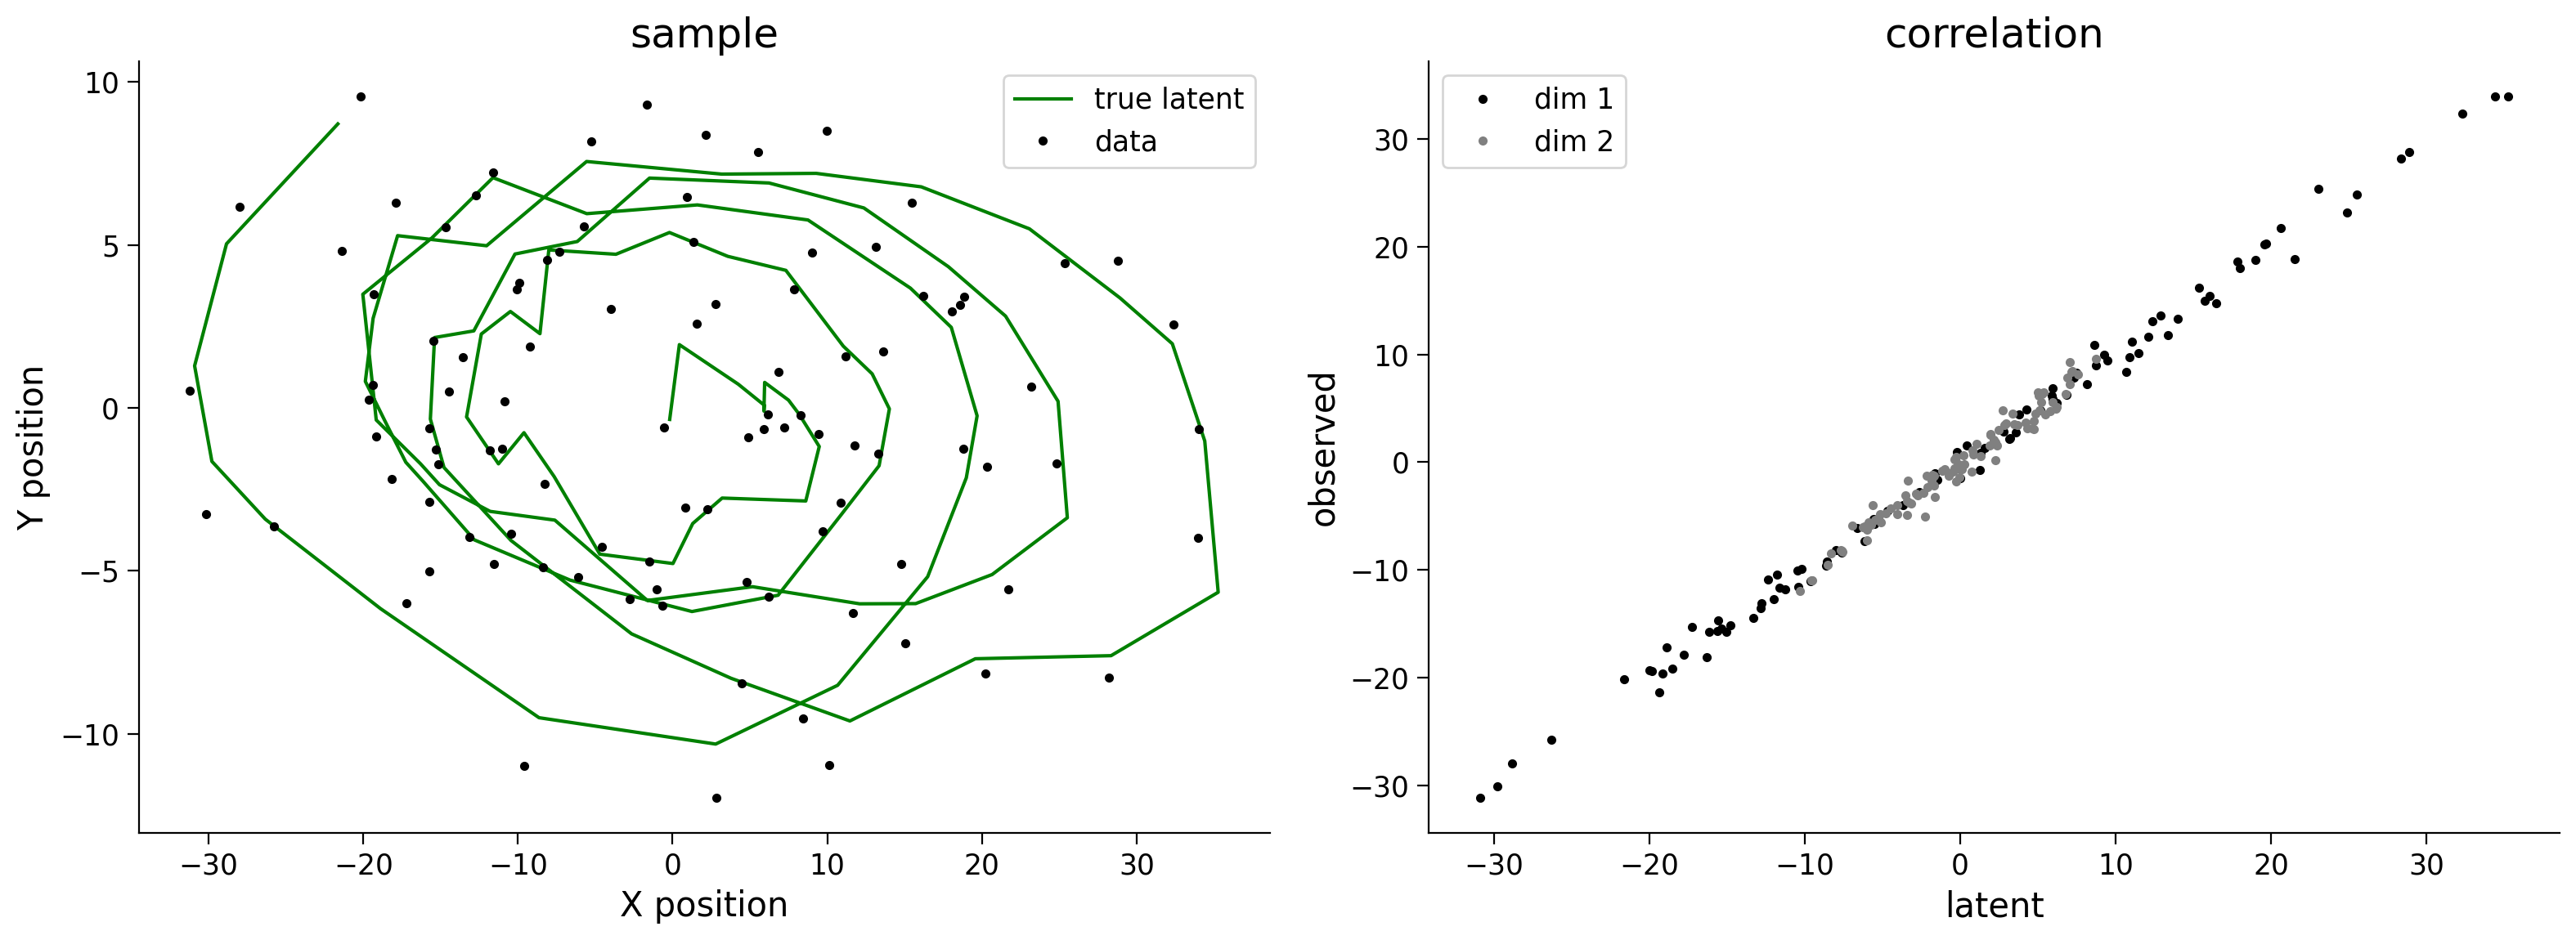

In [ ]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'F': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 1.0 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

state, obs = sample_lds(100, params)
plot_kalman(state, obs, title='sample')

## Exercise 2: Implement Kalman filtering
In this exercise you will implement the Kalman filter (forward) process. Your focus will be on writing the expressions for the Kalman gain, filter mean, and filter covariance at each time step (refer to the equations above).

(<Axes: title={'center': 'my kf-filter'}, xlabel='X position', ylabel='Y position'>,
 <Axes: title={'center': 'correlation'}, xlabel='real latent', ylabel='estimated latent'>)

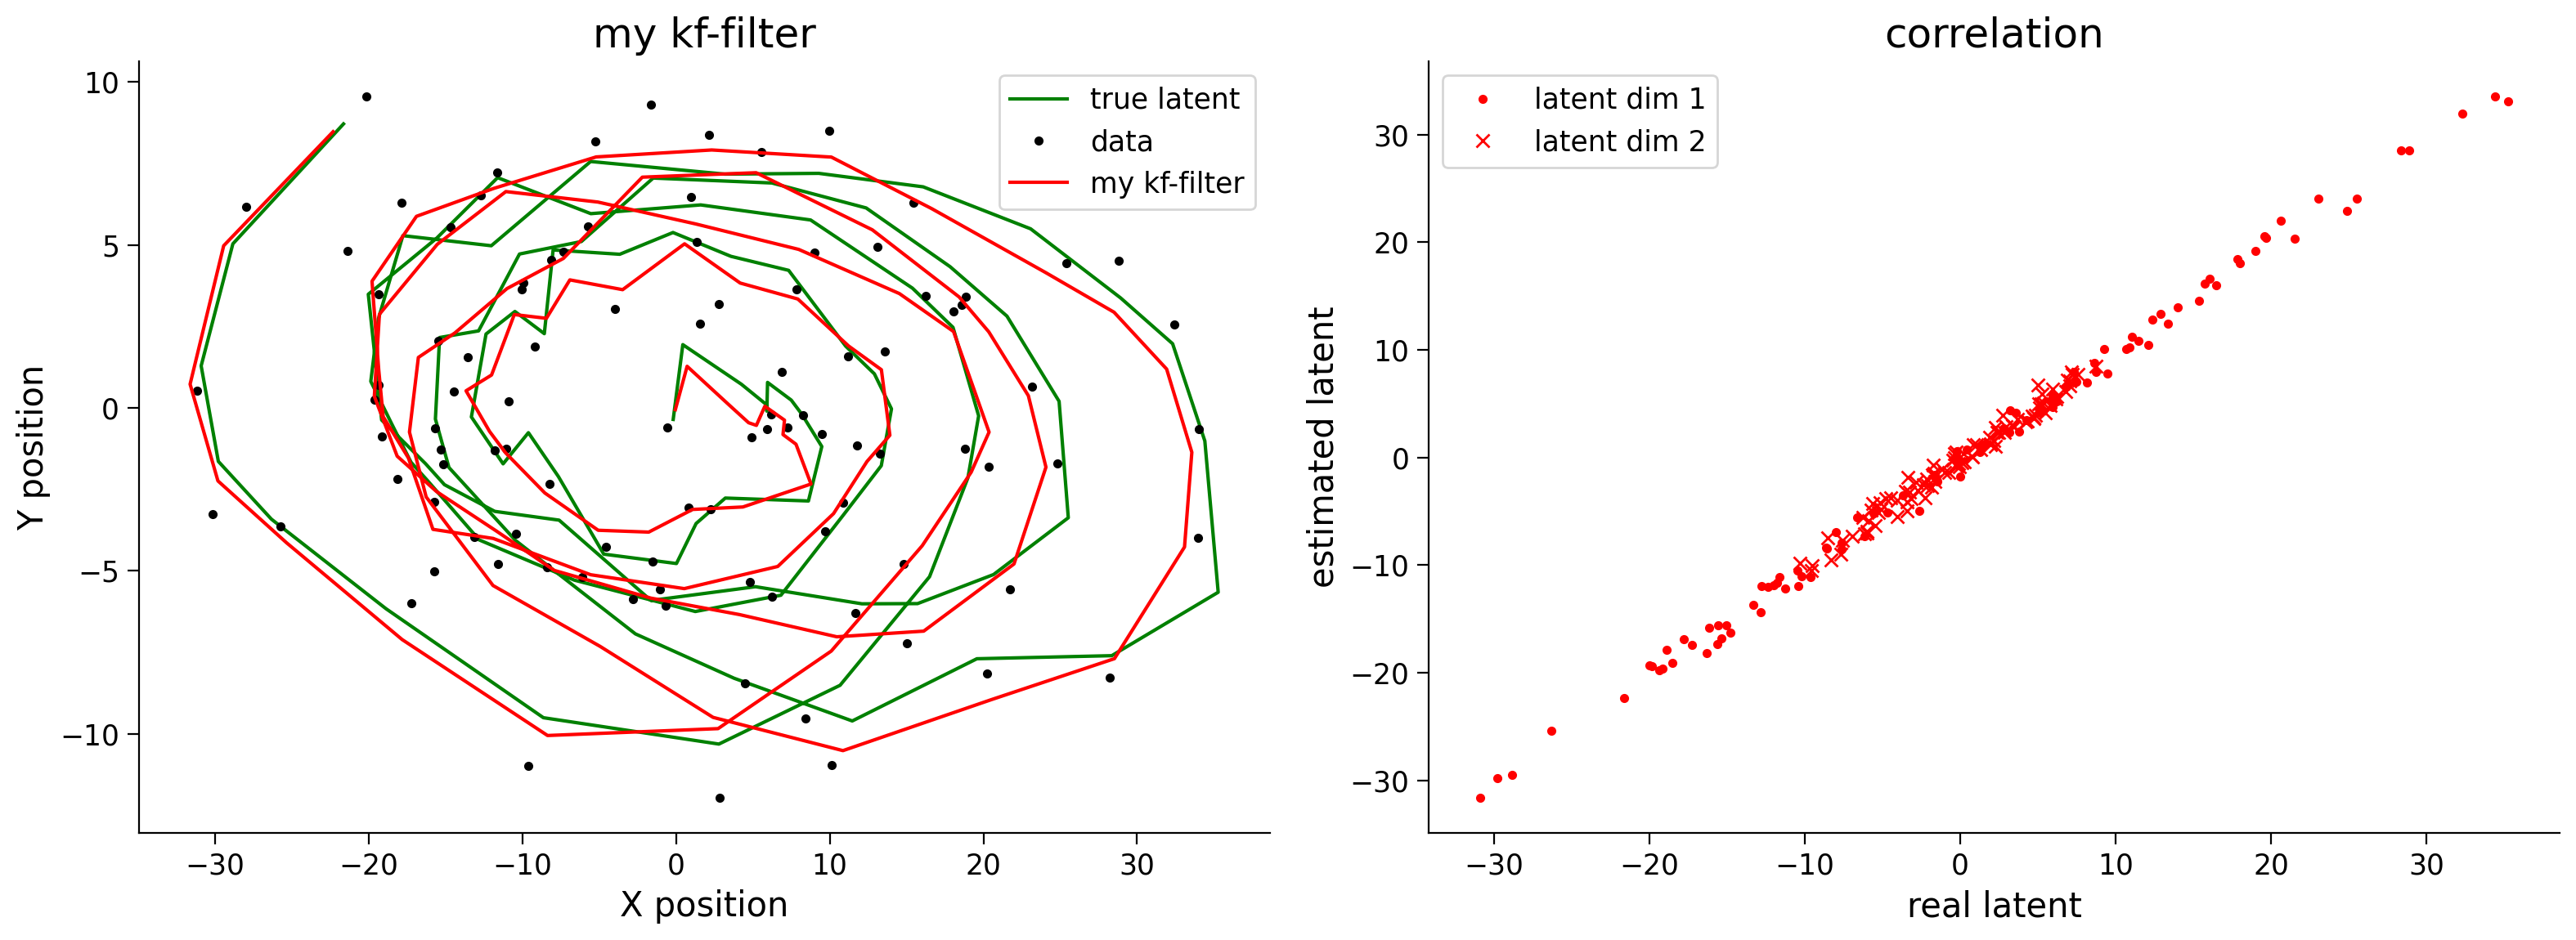

In [12]:
def kalman_filter(data, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]
  I = np.eye(n_dim_state)  # identity matrix

  # state tracking arrays
  mu = np.zeros((len(data), n_dim_state))
  sigma = np.zeros((len(data), n_dim_state, n_dim_state))

  # filter the data
  for t, y in enumerate(data):
    if t == 0:
      mu_pred = params['mu_0']
      sigma_pred = params['sigma_0']
    else:
      #### TODO prediction of the state and covariance at time t ####
      mu_pred = F @ mu[t-1]
      sigma_pred = F @ sigma[t-1] @ F.T + Q

    #### TODO write the expression for computing the Kalman gain ####
    K = sigma_pred @ H.T @ np.linalg.inv(H @ sigma_pred @ H.T + R)

    #### TODO write the expression for computing the filtered state mean ####
    mu[t] = mu_pred + K @ (y - H @ mu_pred)

    #### TODO write the expression for computing the filtered state noise covariance ####
    sigma[t] = (I - K @ H) @ sigma_pred

  return mu, sigma


filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)

plot_kalman(state, obs, filtered_state_means, title="my kf-filter",
              color='r', label='my kf-filter')

*Example output:*

<img alt='Solution hint' align='left' width=1133 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_e9df5afe_0.png>



# Linear Dynamical Systems & The Kalman Filter

**Acknowledgement**

This tutorial is in part based on code originally created by Caroline Haimerl for Dr. Cristina Savin's *Probabilistic Time Series* class at the Center for Data Science, New York University